### Практическое задание к уроку 5
Реализовать оценку Out-of-Bag ошибок для каждого из деревьев леса

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [10]:
class RandomForest:
    
    class Node:
    
        def __init__(self, index, t, true_branch, false_branch):
            self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t  # значение порога
            self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
            self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        

    class Leaf:

        def __init__(self, data, labels):
            self.data = data
            self.labels = labels
            self.prediction = self.predict()

        def predict(self):
            # подсчет количества объектов разных классов
            classes = {}  # сформируем словарь "класс: количество объектов"
            for label in self.labels:
                if label not in classes:
                    classes[label] = 0
                classes[label] += 1
            #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
            prediction = max(classes, key=classes.get)
            return prediction  
    
    
    def __init__(self, method='gini', random_state=None):
        self.method = method
        self._random_state = random_state
        
    def _H(self, labels):
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        if self.method == 'entropy':
            impurity = 0
            for label in classes:
                p = classes[label] / len(labels)
                # Если p равна нулю, то не изменяем impurity, т.к. полагается, что 0*np.log2(0)=0
                if p != 0:
                    impurity -= p * np.log2(p)
        else:
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2

        return impurity

    def _quality(self, left_labels, right_labels, current_H):

        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_H - p * self._H(left_labels) - (1 - p) * self._H(right_labels)

    @staticmethod
    def _split(data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Генерация подмножества признаков
    @staticmethod
    def _get_subsample(len_sample):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(len_sample)]

        len_subsample = int(np.sqrt(len_sample))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample

    def _find_best_split(self, data, labels):

        #  обозначим минимальное количество объектов в узле
        min_leaf = 1

        current_H = self._H(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]
        
        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self._get_subsample(n_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 1 объекта
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_H)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index  
    
    def _build_tree(self, data, labels, current_deep):
        
        if current_deep is not None:
            if current_deep == 0:
                return self.Leaf(data, labels)
            current_deep -= 1
        
        quality, t, index = self._find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return self.Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self._build_tree(true_data, true_labels, current_deep)
        false_branch = self._build_tree(false_data, false_labels, current_deep)
    
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, true_branch, false_branch)
        
    def _classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)

    def _predict(self, data, tree):

        classes = []
        for obj in data:
            prediction = self._classify_object(obj, tree)
            classes.append(prediction)
        return classes
    
    # Генерация bootstrap выборок
    def _get_bootstrap(self, data, labels, N):
        if self._random_state is not None:
            random.seed(self._random_state)
        n_samples = data.shape[0]
        bootstrap = []
        # Множество с индексами для отбора индексов для OOB
        n_samples_set = set(range(n_samples))
        # Список индексов OOB
        OOB_indexes_list = []
        # Словарь, хранящий индексы данных в ключе и список деревьев не обучавшихся на этих данных
        OOB_indexes_dict = {index: [] for index in range(train_data.shape[0])}

        for i in range(N):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)
            indexes_set = set()
            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
                indexes_set.add(sample_index)
            bootstrap.append((b_data, b_labels))
            # Формирую список индексов данных OOB
            OOB_indexes = indexes_set.symmetric_difference(n_samples_set)
            OOB_indexes_list.append(list(OOB_indexes))

        # Заполняю словарь
        for i, tree in enumerate(OOB_indexes_list):
            for index in tree:
                OOB_indexes_dict[index].append(i)

        return bootstrap, OOB_indexes_dict

    @staticmethod
    def _get_OOB_score(trees_preds, labels):
        OOB_score = [0] * len(trees_preds)

        for i, tree in enumerate(trees_preds):
            correct_preds = 0
            for lable, prediction in tree:
                if prediction == labels[lable]:
                    correct_preds += 1
            OOB_score[i] = correct_preds / len(tree)
        return OOB_score
    
    def _OOB_score(self, forest, data, labels, OOB_indexes):
        trees_preds = [[] for _ in range(len(forest))]
        for index, trees_list in OOB_indexes.items():
            predictions = []
            if trees_list:
                for tree in trees_list:
                    predictions.append(self._classify_object(data[index], forest[tree]))
                current_prediction = max(set(predictions), key=predictions.count)
                for tree in trees_list:
                    trees_preds[tree].append((index, current_prediction))
        return self._get_OOB_score(trees_preds, labels)

    def build(self, data, labels, n_trees, max_deep=None):
        self.forest = []
        bootstrap, OOB_indexes = self._get_bootstrap(data, labels, n_trees)

        for b_data, b_labels in bootstrap:
            self.forest.append(self._build_tree(b_data, b_labels, max_deep))
        
        self.OOBS = self._OOB_score(self.forest, data, labels, OOB_indexes)
    
    # предсказание голосованием деревьев
    def predict(self, data):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            predictions.append(self._predict(data, tree))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

In [33]:
def accuracy_metric(actual, predicted):
  correct = 0
  for i in range(len(actual)):
      if actual[i] == predicted[i]:
          correct += 1
  return correct / float(len(actual)) * 100.0

In [30]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

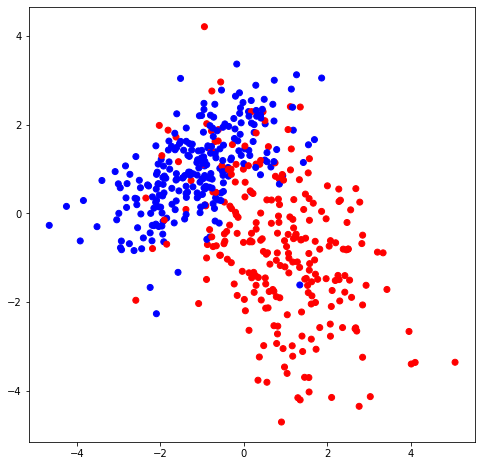

In [31]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [32]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [34]:
n_trees = 5

In [35]:
my_forest = RandomForest(random_state=42)

In [36]:
my_forest.build(train_data, train_labels, n_trees)

In [37]:
my_forest.OOBS

[0.8345864661654135,
 0.8429752066115702,
 0.8387096774193549,
 0.8854961832061069,
 0.9047619047619048]

In [38]:
train_answers = my_forest.predict(train_data)

In [39]:
test_answers = my_forest.predict(test_data)

In [40]:
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 5 деревьев на обучающей выборке: 97.714


In [41]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 5 деревьев на тестовой выборке: 94.667
